In [42]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, Activation, Dropout, Concatenate
from tensorflow.keras import Model, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50

In [70]:
# paths
DIR = ('/Users/allankapoor/Documents/Springboard/structure_damage/')
train_path = os.path.join(DIR, 'data', 'train_another')
val_path = os.path.join(DIR, 'data', 'validation_another')
test_path = os.path.join(DIR, 'data', 'test')

## Load Training/Validation/Test Data

### Simple Loading
First I load the training and validation sets as-is with no image augmentation. I'll use this for the first baseline model.

In [40]:
image_size = (128, 128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_path,
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 10000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### Loading with Image Augmentation
Below I leverage the keras ImageDataGenerator to add an image augmentation pipeline. AS the training dataset is rather small (10,000 images), this will create more variation in the training dataset to reduce model overfitting and improve performance.

I limited image augmentation to a few types that are similar to the kinds of variation that might be caused by differences between instances of structures, as well as differences due to the how imagery aircraft fly.

Note that we do not do any image augmentation for the validation data.

In [3]:
image_size = (128, 128)
batch_size = 100

# TRAINING
# specify training image transformations 
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True)

# keras generator for training data
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')


# VALIDATION
# specify validation image transformations (rescale only)
val_datagen = ImageDataGenerator(rescale=1./255)

# keras generator for validation data
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='binary')

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Functions for evaluating model performance

As this is a binary classification problem with equal sized classes, I will use accuracy to evaluate the performance of the models. Below I define a function which plots the training and validation accuracy and loss over all epochs. This will enable me to inspect the training process visually. If training accuracy increases close to 1.0 but validation accuracy stays poor, I will know the model is overfitting. If validation accuracy 

In [4]:
def plot_nn_training(history):
    
    '''Given model training history, plots validation accuracy and loss'''
    
    # plot history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # plot history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Baseline Model - No Image Augmentation

I start by training a simple baseline model using the sequential API.The model architecture includes 3 convolution layers (with batch normalization and ReLu activation), followed by 3 dense layers with ReLu activation, and then an ouput layer with Softmax activation. Training data is used as-is with no image augmentation. 

As expected, the model does not perform well on validation data. Training accuracy is reaching XX but validation accuracy is XX. This suggests that the model is overfitting the training data. It is also training quite slowly. I will address both of these issues in later models.

In [51]:
# create model
model = Sequential()

# scaling 
model.add(Rescaling(1.0 / 255))

# convolution layers
model.add(Conv2D(32, kernel_size=5, strides=2, padding="same", input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(64, kernel_size=3, padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))

# flatten
model.add(Flatten())

# dense layers
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))

# output layer
model.add(Dense(2, activation='softmax'))

In [52]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model1/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [53]:
# train model
results1 = model.fit(
    train_ds,
    epochs=50,
    callbacks= [es, mc],
    validation_data=val_ds)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
313/313 [==============================] - ETA: 0s - loss: 6.4516 - accuracy: 0.7474WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4577521f0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

**Accuracy:** 0.94650

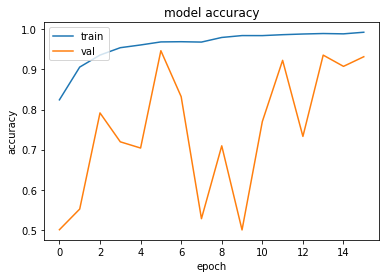

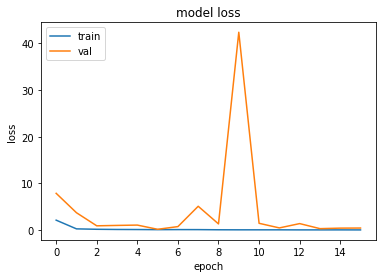

In [57]:
#plot performance by epoch 
plot_nn_training(results1)

## Baseline Model - With Image Augmentation

Perhaps the model performing poorly because it is overfitting to the relatively small training dataset (there are only 10,000 images). This can be addressed by image augmentation (see above for the image augmentation pipeline).

Below I train the same baseline model, but use the image augmentation pipeline developed above to create variation in the training data as it is fed into the model each epoch

In [60]:
# create model
model_img = Sequential()

# scaling 
#model_img.add(Rescaling(1.0 / 255))

# convolution layers
model_img.add(Conv2D(32, kernel_size=5, strides=2, padding="same", input_shape=(128,128,3)))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

model_img.add(Conv2D(64, kernel_size=3, padding="same"))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

model_img.add(Conv2D(64, kernel_size=3, padding="same"))
model_img.add(BatchNormalization())
model_img.add(Activation("relu"))

# flatten
model_img.add(Flatten())

# dense layers
model_img.add(Dense(512, activation='relu'))
model_img.add(Dense(256, activation='relu'))
model_img.add(Dense(128, activation='relu'))

# output layer
model_img.add(Dense(2, activation='softmax'))

In [61]:
# Compile the model
model_img.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model1/best_model_img.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [62]:
# train model
results_img = model_img.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 15.3460 - accuracy: 0.6860WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x1568c4550> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSI


Epoch 00029: val_accuracy did not improve from 0.95650
Epoch 30/50
100/100 [==============================] - 92s 916ms/step - loss: 0.0373 - accuracy: 0.9862 - val_loss: 2.1777 - val_accuracy: 0.7325

Epoch 00030: val_accuracy did not improve from 0.95650
Epoch 31/50
100/100 [==============================] - 87s 871ms/step - loss: 0.0898 - accuracy: 0.9735 - val_loss: 0.3510 - val_accuracy: 0.9435

Epoch 00031: val_accuracy did not improve from 0.95650
Epoch 32/50
100/100 [==============================] - 87s 873ms/step - loss: 0.0300 - accuracy: 0.9906 - val_loss: 0.9669 - val_accuracy: 0.8990

Epoch 00032: val_accuracy did not improve from 0.95650
Epoch 33/50
100/100 [==============================] - 87s 871ms/step - loss: 0.0621 - accuracy: 0.9814 - val_loss: 0.3040 - val_accuracy: 0.9240

Epoch 00033: val_accuracy did not improve from 0.95650
Epoch 34/50
100/100 [==============================] - 86s 862ms/step - loss: 0.0519 - accuracy: 0.9849 - val_loss: 0.1868 - val_accurac

**Accuracy:** 0.95650

## Improving Model Performance

### Adding Max Pooling and Drop Layers

In [28]:
def generate_model2(input_shape, num_classes):
    
    '''CNN model architecture with max pooling + dropout layers'''
    
    inputs = Input(shape=input_shape)
    
    #x = Rescaling(1.0 / 255)
    
    # convolution (with max pooling)
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #flatten
    x = Flatten()(x)
    
    #dense layers (with dropout to avoid overfitting)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # output layer
    output = Dense(2, activation='softmax')(x)
    
    mod = Model(inputs=inputs, outputs=output)
    
    return mod

In [29]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model2/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
model2 = generate_model2(input_shape=(128,128,3), num_classes=2)

# Compile model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [30]:
# train model
results2 = model2.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7655WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ba7764c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

100/100 [==============================] - 22s 216ms/step - loss: 0.0184 - accuracy: 0.9951 - val_loss: 1.0297 - val_accuracy: 0.8355

Epoch 00030: val_accuracy did not improve from 0.96750
Epoch 31/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.2064 - val_accuracy: 0.9415

Epoch 00031: val_accuracy did not improve from 0.96750
Epoch 32/50
100/100 [==============================] - 22s 220ms/step - loss: 0.0254 - accuracy: 0.9911 - val_loss: 0.3249 - val_accuracy: 0.9035

Epoch 00032: val_accuracy did not improve from 0.96750
Epoch 33/50
100/100 [==============================] - 22s 216ms/step - loss: 0.0170 - accuracy: 0.9936 - val_loss: 0.5709 - val_accuracy: 0.8840

Epoch 00033: val_accuracy did not improve from 0.96750
Epoch 34/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0210 - accuracy: 0.9935 - val_loss: 0.2032 - val_accuracy: 0.9560

Epoch 00034: val_accuracy did not improve from 0.96750
Ep

**Accuracy:** 0.96750

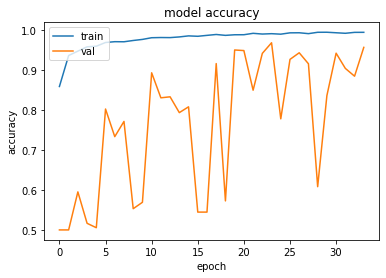

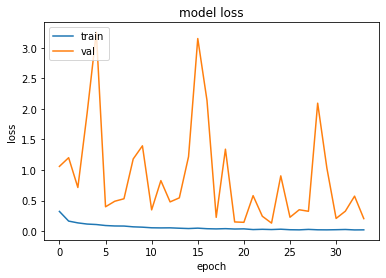

In [31]:
plot_nn_training(results2)

In [32]:
# model with less dense nodes - will train faster, but will it be as accurate?
def generate_model3(input_shape, num_classes):
    
    '''CNN model architecture with max pooling + dropout layers'''
    
    inputs = Input(shape=input_shape)
    
    #x = Rescaling(1.0 / 255)
    
    # convolution (with max pooling)
    x = Conv2D(32, kernel_size=5, strides=2, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x) 
    x = BatchNormalization()(x) # why?
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #flatten
    x = Flatten()(x)
    
    #dense layers (with dropout to avoid overfitting)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # output layer
    output = Dense(2, activation='softmax')(x)
    
    mod = Model(inputs=inputs, outputs=output)
    
    return mod

In [33]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model3/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
model3 = generate_model2(input_shape=(128,128,3), num_classes=2)

# Compile model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [34]:
# train model
results3 = model3.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8102WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x153dd74c0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

100/100 [==============================] - 22s 219ms/step - loss: 0.0149 - accuracy: 0.9960 - val_loss: 2.5216 - val_accuracy: 0.5670

Epoch 00030: val_accuracy did not improve from 0.95100
Epoch 31/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0227 - accuracy: 0.9930 - val_loss: 4.0840 - val_accuracy: 0.5160

Epoch 00031: val_accuracy did not improve from 0.95100
Epoch 32/50
100/100 [==============================] - 22s 219ms/step - loss: 0.0244 - accuracy: 0.9898 - val_loss: 2.5413 - val_accuracy: 0.6155

Epoch 00032: val_accuracy did not improve from 0.95100
Epoch 33/50
100/100 [==============================] - 22s 218ms/step - loss: 0.0190 - accuracy: 0.9934 - val_loss: 0.2527 - val_accuracy: 0.9535

Epoch 00033: val_accuracy improved from 0.95100 to 0.95350, saving model to models/Model3/best_model.h5
Epoch 34/50
100/100 [==============================] - 23s 226ms/step - loss: 0.0176 - accuracy: 0.9932 - val_loss: 0.8564 - val_accuracy: 0.8075

Epoch 00

**Accuracy:** 0.95350

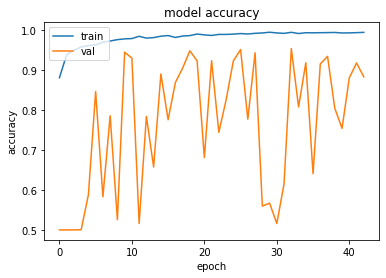

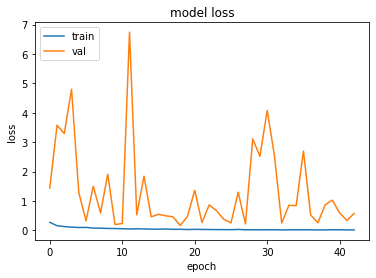

In [35]:
plot_nn_training(results3)

In [37]:
def generate_model4(input_shape, num_classes):
    
    '''CNN model architecture with max pooling + dropout layers'''
    
    inputs = Input(shape=input_shape)
    
    # convolution (with max pooling)
    x = Conv2D(32, kernel_size=10, strides=2, padding="same")(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x) 
    x = BatchNormalization()(x) # why?
    x = Activation("relu")(x)

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    #flatten
    x = Flatten()(x)
    
    #dense layers (with dropout to avoid overfitting)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.1)(x)
    
    # output layer
    output = Dense(2, activation='softmax')(x)
    
    mod = Model(inputs=inputs, outputs=output)
    
    return mod

In [38]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model4/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
model4 = generate_model2(input_shape=(128,128,3), num_classes=2)

# Compile model
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [39]:
# train model
results4 = model4.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.4228 - accuracy: 0.8025WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2985e05e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT


Epoch 00029: val_accuracy did not improve from 0.95000
Epoch 30/50
100/100 [==============================] - 36s 360ms/step - loss: 0.0290 - accuracy: 0.9879 - val_loss: 0.2457 - val_accuracy: 0.9070

Epoch 00030: val_accuracy did not improve from 0.95000
Epoch 31/50
100/100 [==============================] - 36s 356ms/step - loss: 0.0202 - accuracy: 0.9934 - val_loss: 4.9678 - val_accuracy: 0.6085

Epoch 00031: val_accuracy did not improve from 0.95000
Epoch 32/50
100/100 [==============================] - 36s 357ms/step - loss: 0.0267 - accuracy: 0.9913 - val_loss: 3.1255 - val_accuracy: 0.5430

Epoch 00032: val_accuracy did not improve from 0.95000
Epoch 33/50
100/100 [==============================] - 35s 352ms/step - loss: 0.0296 - accuracy: 0.9896 - val_loss: 0.1581 - val_accuracy: 0.9655

Epoch 00033: val_accuracy improved from 0.95000 to 0.96550, saving model to models/Model3/best_model.h5
Epoch 34/50
100/100 [==============================] - 36s 354ms/step - loss: 0.0200 - 

**Accuracy:** 0.96550

In [ ]:
plot_nn_training(results4)

## Transfer Learning

In [63]:
def generate_TL_model(input_shape, num_classes):
    
    weights = 'imagenet'
    inputs = Input(input_shape)

    #what does include_top=False remove?
    base_model = ResNet50(include_top=False, weights=weights, input_shape=(128, 128, 3))

    #freezing the resnet layers
    for layer in base_model.layers:
        layer.trainable = False

    #these convolution layers come before the resnet layers
    x = Conv2D(32, (5, 5), strides=2, padding='same', activation='relu', input_shape=(128, 128, 3))(inputs)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)

    x = Flatten()(x)

    base_resnet = base_model(inputs)
    base_resnet = Flatten()(base_resnet)

    concated_layers = Concatenate()([x, base_resnet])

    # dense layers come after the resnet layers
    # dropout to reduce overfit
    concated_layers = Dense(1024, activation='relu')(concated_layers)
    concated_layers = Dropout(0.3)(concated_layers)
    concated_layers = Dense(512, activation='relu')(concated_layers)
    concated_layers = Dropout(0.2)(concated_layers)
    concated_layers = Dense(256, activation='relu')(concated_layers)
    concated_layers = Dropout(0.1)(concated_layers)
    
    # output layer
    output = Dense(num_classes, activation='softmax')(concated_layers)

    mod = Model(inputs=inputs, outputs=output)
    
    return mod

In [64]:
epochs = 100

# patient early stopping
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

# save best model
mc = ModelCheckpoint('models/Model5/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Instantiate model
TL_model = generate_TL_model(input_shape=(128,128,3), num_classes=2)

# Compile model
TL_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [65]:
# train model
results_TL = TL_model.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 2.8596 - accuracy: 0.7267WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x4679d2ca0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

100/100 [==============================] - 291s 3s/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.1294 - val_accuracy: 0.9610

Epoch 00030: val_accuracy did not improve from 0.97450
Epoch 31/50
100/100 [==============================] - 249s 2s/step - loss: 0.0285 - accuracy: 0.9913 - val_loss: 0.0895 - val_accuracy: 0.9695

Epoch 00031: val_accuracy did not improve from 0.97450
Epoch 00031: early stopping


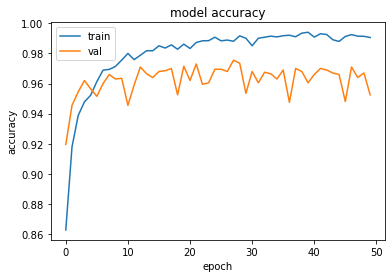

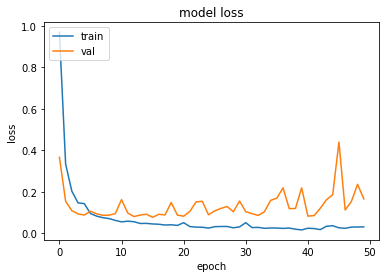

In [15]:
plot_nn_training(TL_model_fit)

## Test performance

In [67]:
# load best performing model
from tensorflow.keras.models import load_model

best_model = load_model('models/Model5/best_model.h5')

In [68]:
best_model

In [71]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2000 files belonging to 2 classes.


In [ ]:
eval_results = best_model.evaluate(test_ds)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-12-05 14:30:58.292571: I tensorflow/compiler/tf2mlcompute/kernels/mlc_subgraph_op.cc:537] Compute: Failed in processing TensorFlow graph model_10/MLCSubgraphOp_30_0 with error: Internal: ExecuteMLCInferenceGraph: Failed to execute MLC inference graph. (error will be reported 5 times unless TF_MLC_LOGGING=1).


In [ ]:
eval_results

In [23]:
# Instantiate and compile model
epochs = 20
#callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]
TL_model_2 = generate_TL_model(input_shape=(128,128,3), num_classes=2)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
TL_model_2.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

# train model
TL_model_2_fit = TL_model_2.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 0.4528 - accuracy: 0.8354WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x408e2e040> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

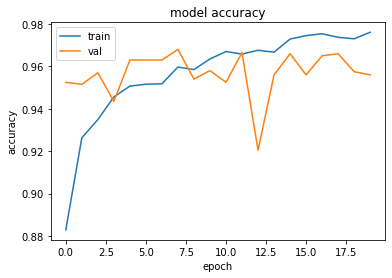

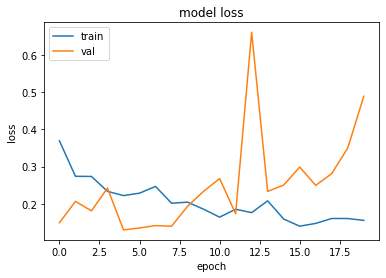

In [24]:
plot_nn_training(TL_model_2_fit)

In [11]:
# Instantiate and compile model
epochs = 50
#callbacks = [keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5")]

TL_model_2 = generate_TL_model(input_shape=(128,128,3), num_classes=2)

TL_model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [13]:
# train model
TL_model_2_fit = TL_model_2.fit(
    train_generator,
    steps_per_epoch=100, # num_samples//batch_size
    epochs=50,
    #callbacks= [es, mc],
    validation_data=validation_generator,
    validation_steps=20) # num_samples//batch_size

Epoch 1/50
100/100 [==============================] - 242s 2s/step - loss: 0.0395 - accuracy: 0.9863 - val_loss: 0.1040 - val_accuracy: 0.9700
Epoch 2/50
 13/100 [==>...........................] - ETA: 3:00 - loss: 0.0528 - accuracy: 0.9800

KeyboardInterrupt: 

In [12]:
# train model
TL_model_2_fit = TL_model_2.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
100/100 [==============================] - ETA: 0s - loss: 2.8344 - accuracy: 0.7701WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2c3c6f430> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSIT

KeyboardInterrupt: 